# 1.0 - Exploratory Data Analysis (EDA)

Purpose:

- Understand the Xente transactions data used to build the BNPL risk model.
- Inspect quality (missing values, types), distributions, and target balance (`is_high_risk`).
- Explore time patterns and categorical breakdowns.
- Sanity-check RFM metrics that drive the proxy label.


### Import Libraries


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from collections import defaultdict

### Load the dataset


In [ ]:
# Robust data loader: prefer processed CSV, else fall back to raw CSV/Excel
import os
from pathlib import Path

candidates = [
    Path('..') / 'data' / 'processed' / 'processed_data.csv',
    Path('..') / 'data' / 'raw' / 'raw_data.csv',
    Path('..') / 'data' / 'raw' / 'raw_data.xlsx',
    Path('..') / 'data' / 'raw' / 'data.xlsx',
]

loaded = False
for p in candidates:
    if p.exists():
        try:
            if p.suffix.lower() == '.csv':
                df = pd.read_csv(p)
            else:
                df = pd.read_excel(p, engine='openpyxl')
            print(f"Loaded: {p}")
            loaded = True
            break
        except Exception as e:
            print(f"Failed to load {p}: {e}")

if not loaded:
    raise FileNotFoundError(
        "No dataset found in ../data/processed or ../data/raw")

# Clean obvious export artifacts
for col in ['Unnamed: 16', 'Unnamed: 17']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Parse datetime if present
if 'TransactionStartTime' in df.columns:
    df['TransactionStartTime'] = pd.to_datetime(
        df['TransactionStartTime'], errors='coerce')

df.shape

In [ ]:
# Identify target and time columns with fallbacks
# Prefer proxy label generated in processing, else fall back to raw fraud flag
_target_candidates = ['is_high_risk', 'FraudResult']
target_col = next((c for c in _target_candidates if c in df.columns), None)
if target_col:
    print(f"Using target column: {target_col}")
else:
    print("No target column found; target-specific analyses will be skipped.")

# Identify a datetime column and ensure it's parsed
_time_candidates = ['TransactionStartTime', 'transaction_start_time',
                    'TransactionDate', 'CreatedAt', 'timestamp']
time_col = next((c for c in _time_candidates if c in df.columns), None)
if time_col:
    try:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        print(f"Using datetime column: {time_col}")
    except Exception as e:
        print(f"Failed to parse {time_col} as datetime: {e}")
        time_col = None
else:
    print("No datetime column detected; time-series charts will be skipped.")

### Summary Statistics


In [25]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Unnamed: 16,Unnamed: 17
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.0,2018-11-15T02:18:49Z,2.0,0,January542024,NaN
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,NaN,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.0,2018-11-15T02:19:08Z,2.0,0,February33932024,202455March
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,NaN,ProductId_1,airtime,ChannelId_3,500.0,500.0,2018-11-15T02:44:21Z,2.0,0,March552026,202554March
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,NaN,2018-11-15T03:32:55Z,2.0,0,April542027,202454March
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,NaN,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.0,2018-11-15T03:34:21Z,2.0,0,May542028,202554March


In [26]:
df.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'Unnamed: 16',
       'Unnamed: 17'],
      dtype='object')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95660 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95660 non-null  float64
 7   ProviderId            95660 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95659 non-null  float64
 13  TransactionStartTime  95661 non-null  object 
 14  PricingStrategy       95659 non-null  float64
 15  FraudResult        

In [ ]:
# Drop leftover unnamed columns if still present
_cols_to_drop = [c for c in ['Unnamed: 16', 'Unnamed: 17'] if c in df.columns]
if _cols_to_drop:
    df = df.drop(columns=_cols_to_drop)

print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

Rows: 95662
Columns: 16


In [33]:
df.isnull().sum()
print(df.isnull().mean())

TransactionId           0.000000
BatchId                 0.000000
AccountId               0.000021
SubscriptionId          0.000000
CustomerId              0.000000
CurrencyCode            0.000000
CountryCode             0.000021
ProviderId              0.000021
ProductId               0.000000
ProductCategory         0.000000
ChannelId               0.000000
Amount                  0.000000
Value                   0.000031
TransactionStartTime    0.000010
PricingStrategy         0.000031
FraudResult             0.000000
dtype: float64


In [34]:
print(df.describe(include="all"))

              TransactionId        BatchId       AccountId  \
count                 95662          95662           95660   
unique                95662          94809            3633   
top     TransactionId_76871  BatchId_67019  AccountId_4841   
freq                      1             28           30893   
mean                    NaN            NaN             NaN   
std                     NaN            NaN             NaN   
min                     NaN            NaN             NaN   
25%                     NaN            NaN             NaN   
50%                     NaN            NaN             NaN   
75%                     NaN            NaN             NaN   
max                     NaN            NaN             NaN   

             SubscriptionId       CustomerId CurrencyCode  CountryCode  \
count                 95662            95662        95662      95660.0   
unique                 3627             3742            1          NaN   
top     SubscriptionId_3829  Cust

In [ ]:
for col in ['FraudResult', 'CountryCode', 'PricingStrategy', 'Value']:
    if col in df.columns:
        print(f"\n{col} value counts:\n",
              df[col].value_counts(dropna=False).head(20))
    else:
        print(f"{col} not in dataframe; skipping counts.")

FraudResult
0    95469
1      193
Name: count, dtype: int64
CountryCode
256.0    95660
Name: count, dtype: int64
PricingStrategy
2.0    79849
4.0    13558
1.0     1867
0.0      385
Name: count, dtype: int64
Value
1000.0      19407
5000.0       9376
50.0         8526
10000.0      7944
500.0        5806
            ...  
35100.0         1
12300.0         1
8830.0          1
149000.0        1
5890.0          1
Name: count, Length: 1517, dtype: int64


In [ ]:
# Ensure datetime parsing using detected time column
if 'time_col' in globals() and time_col:
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
else:
    print('No time column available; skipping datetime parsing.')

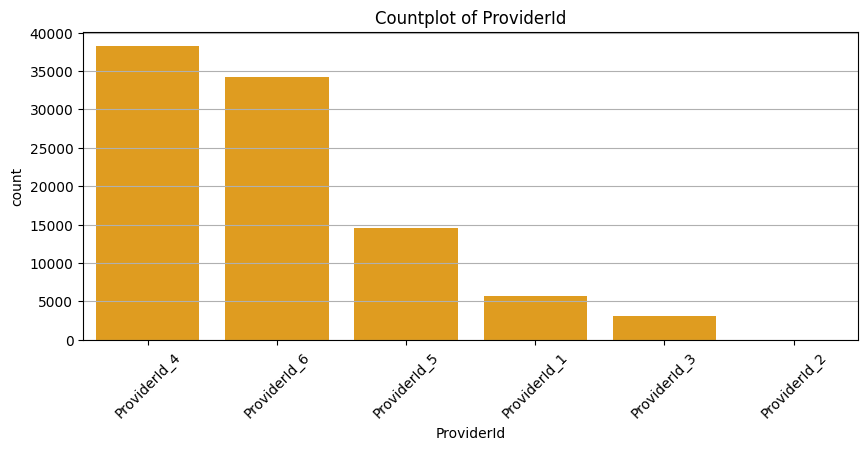

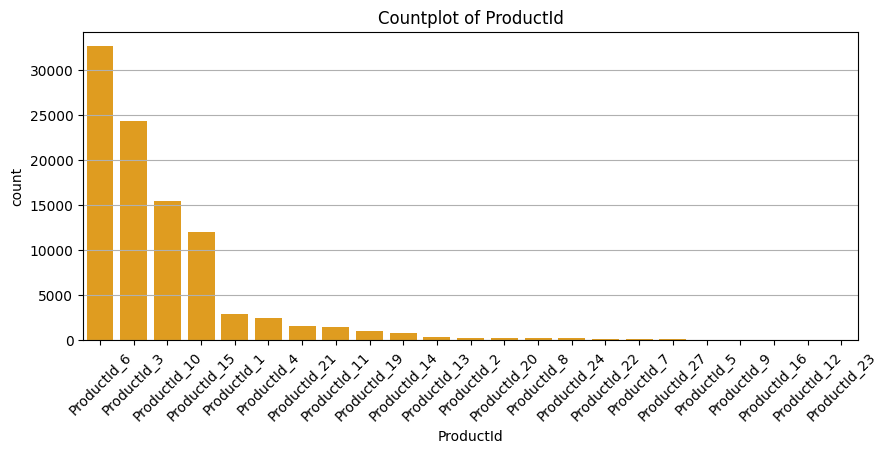

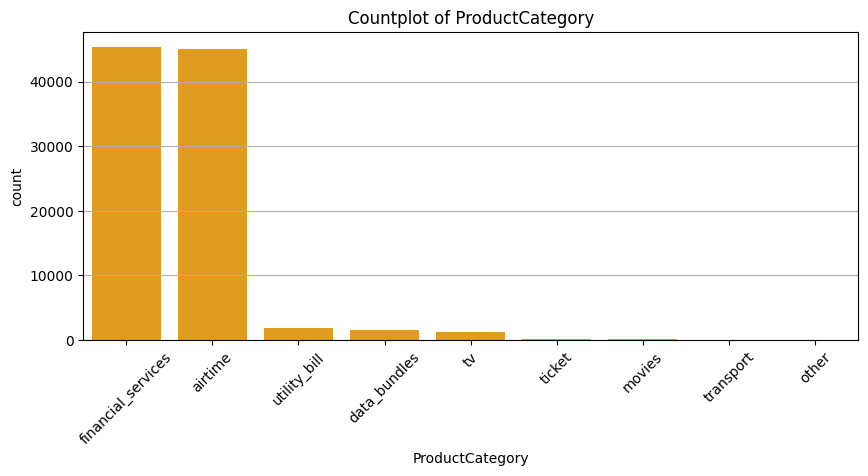

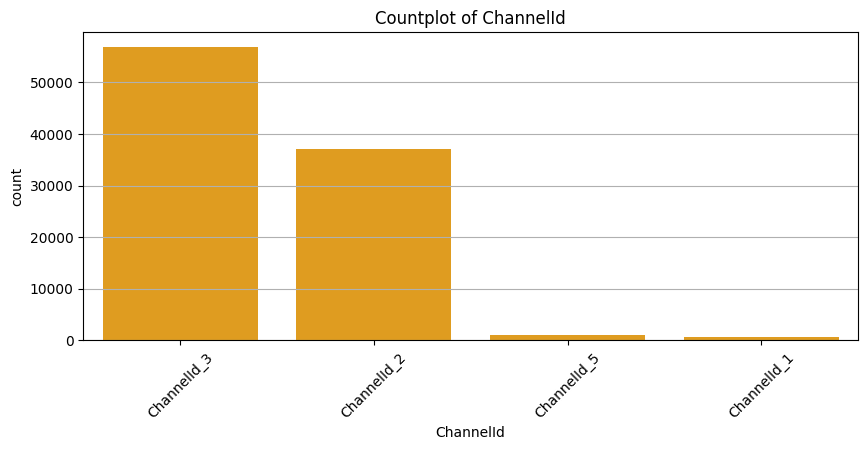

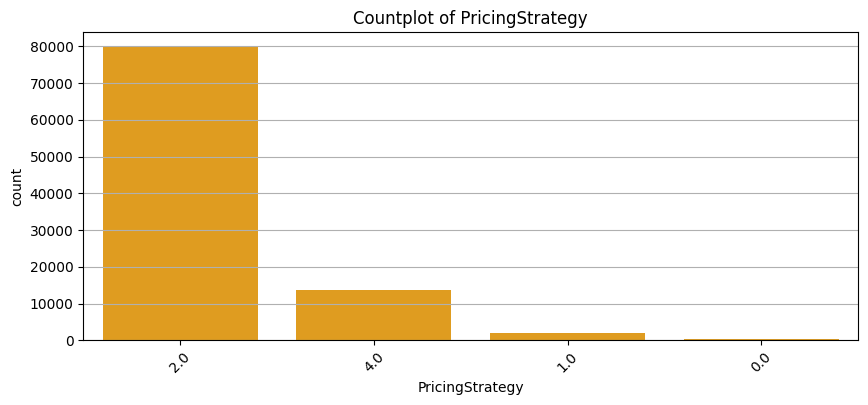

In [ ]:
# Visualize categorical features if present
categorical_cols = [
    'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy'
]
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col,
                      order=df[col].value_counts().index, color='orange')
        plt.title(f'Countplot of {col}')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
        plt.show()
    else:
        print(f"Skipping {col}, not found in dataframe.")

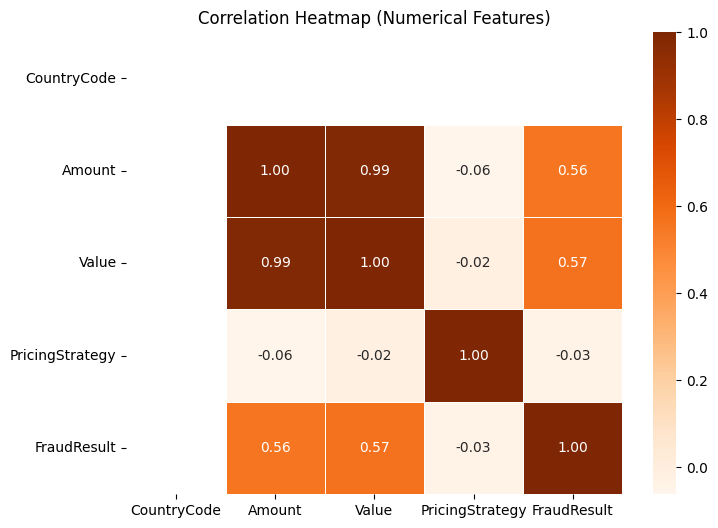

In [ ]:
# Correlation heatmap for numerical features (robust)
numeric_cols = df.select_dtypes(include=['number']).columns
if len(numeric_cols) >= 2:
    plt.figure(figsize=(8, 6))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='Oranges', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap (Numerical Features)')
    plt.show()
else:
    print('Not enough numeric columns to compute a correlation heatmap.')

Amount outliers: 24441 (25.55%)
Lower bound: -4325.00, Upper bound: 7075.00


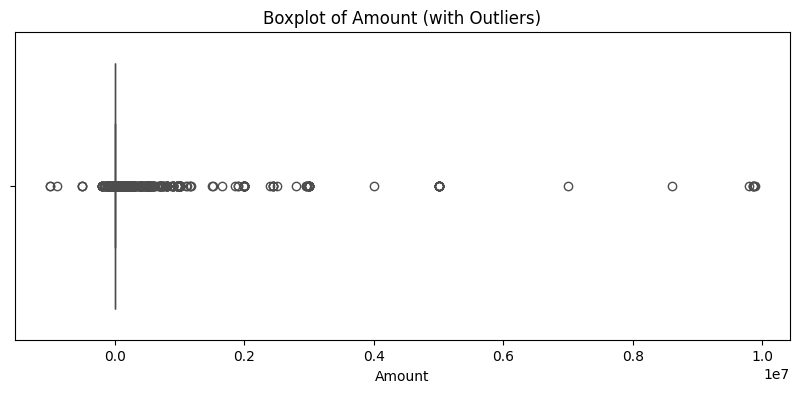

Value outliers: 9020 (9.43%)
Lower bound: -6812.50, Upper bound: 12087.50


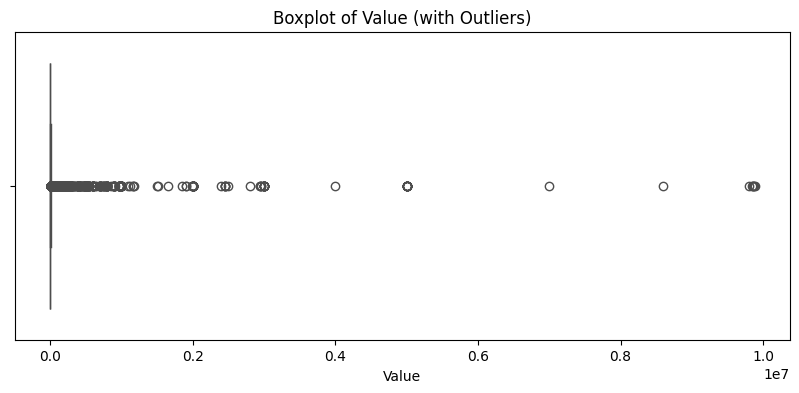

In [ ]:
# Outlier detection using the IQR method for main numerical columns
outlier_summary = defaultdict(dict)
for col in ['Amount', 'Value']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_summary[col]['count'] = outliers.shape[0]
        outlier_summary[col]['percent'] = 100 * outliers.shape[0] / df.shape[0]
        print(
            f"{col} outliers: {outliers.shape[0]} ({outlier_summary[col]['percent']:.2f}%)")
        print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
        # Show a boxplot with outliers
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df[col], color='red')
        plt.title(f'Boxplot of {col} (with Outliers)')
        plt.show()

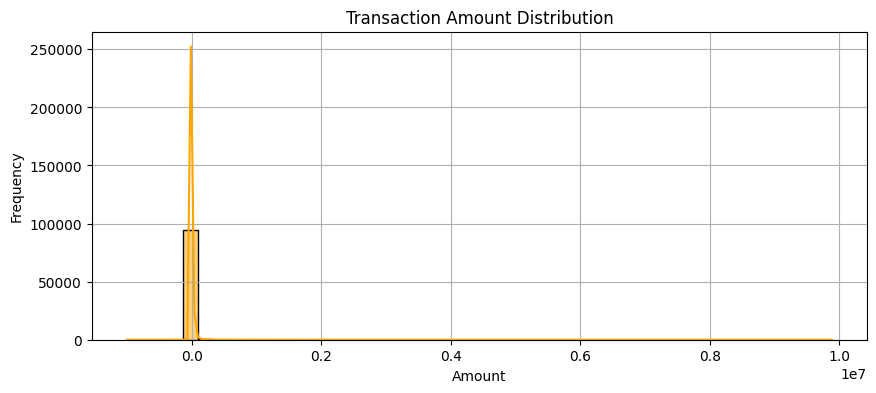

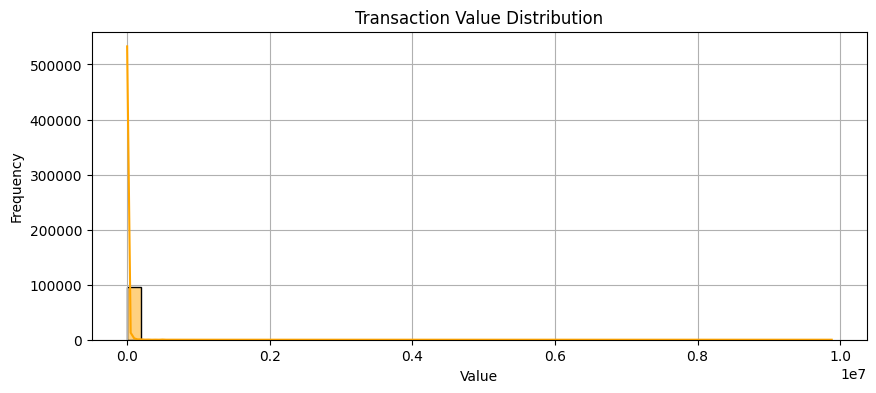

In [ ]:
# Distributions for Amount and Value (robust)
if 'Amount' in df.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df['Amount'], bins=50, kde=True, color='orange')
    plt.title('Transaction Amount Distribution')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print('Skipping Amount distribution: column missing.')

if 'Value' in df.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df['Value'], bins=50, kde=True, color='orange')
    plt.title('Transaction Value Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print('Skipping Value distribution: column missing.')

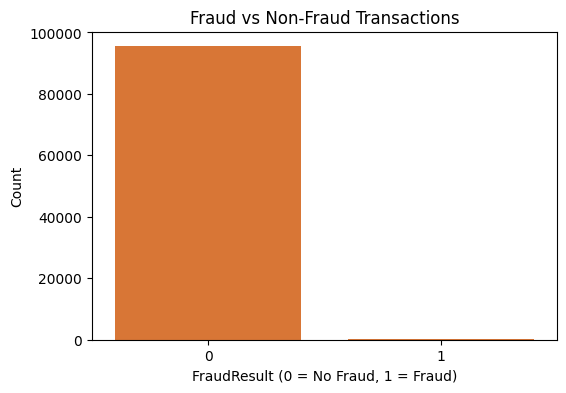

In [ ]:
# Class balance plot (robust to target column name)
if 'target_col' in globals() and target_col:
    color = cm.Oranges(0.6)
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=target_col, color=color)
    plt.title(f'{target_col} distribution')
    plt.xlabel(target_col)
    plt.ylabel('Count')
    plt.show()
else:
    print('Target column missing; skipping class balance plot.')

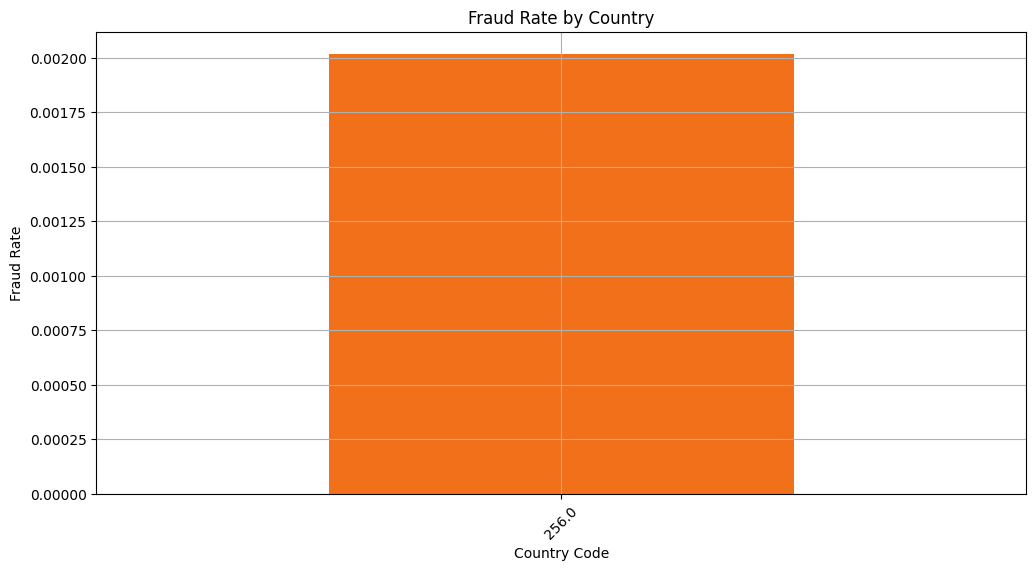

In [ ]:
# Risk rate by Country (robust)
if 'CountryCode' in df.columns and 'target_col' in globals() and target_col:
    rate = df.groupby('CountryCode')[
        target_col].mean().sort_values(ascending=False)
    color = cm.Oranges(0.6)
    plt.figure(figsize=(12, 6))
    rate.head(20).plot(kind='bar', color=color)
    plt.title(f'{target_col} Rate by Country (Top 20)')
    plt.ylabel(f'{target_col} Rate')
    plt.xlabel('Country Code')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
else:
    print('Skipping country risk plot: missing CountryCode or target column.')

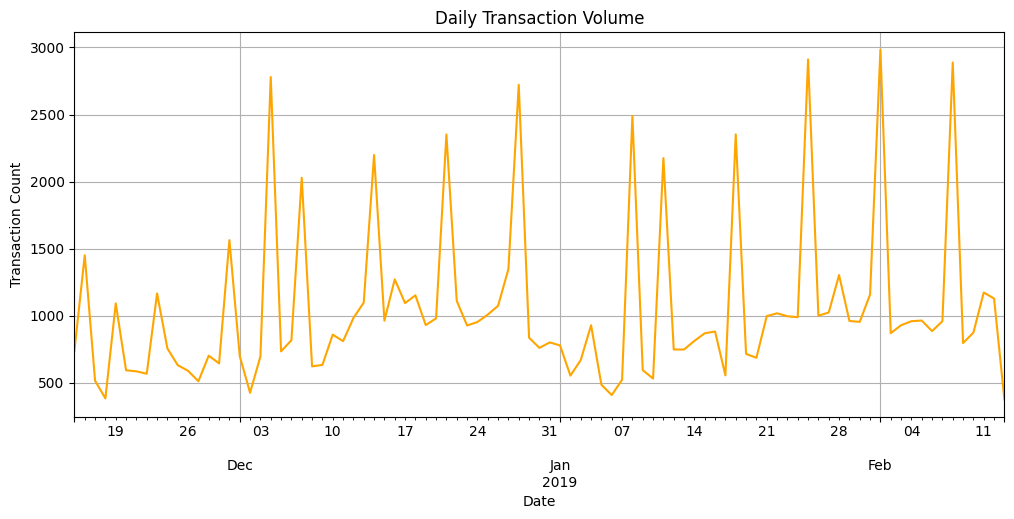

In [ ]:
# Daily transaction volume over time (robust)
if 'time_col' in globals() and time_col and 'Amount' in df.columns:
    # Ensure datetime index for resampling
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df = df.set_index(time_col)
    df = df.sort_index()
    df['Amount'].resample('D').count().plot(figsize=(12, 5), color='orange')
    plt.title('Daily Transaction Volume')
    plt.xlabel('Date')
    plt.ylabel('Transaction Count')
    plt.grid(True)
    plt.show()
else:
    print('Skipping daily volume plot: time or Amount column missing.')

In [16]:
print([c for c in df.columns if df[c].dtype != 'object'])

['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult']


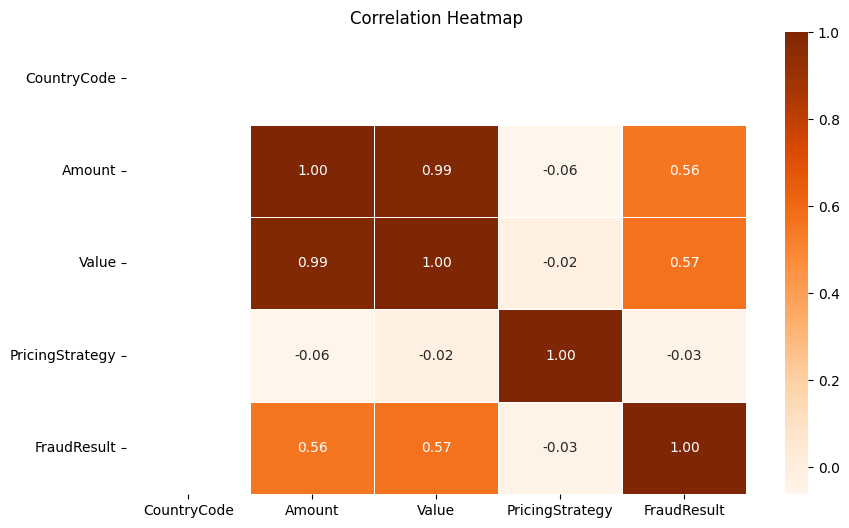

In [ ]:
# Correlation heatmap across selected numeric columns (robust)
_cols = [c for c in ['Amount', 'Value', 'PricingStrategy'] if c in df.columns]
if _cols:
    _num = df[_cols].select_dtypes(include=['number'])
    if _num.shape[1] >= 2:
        plt.figure(figsize=(10, 6))
        sns.heatmap(_num.corr(), annot=True, cmap='Oranges',
                    fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap')
        plt.show()
    else:
        print('Not enough numeric columns for correlation heatmap.')
else:
    print('No selected columns available for correlation heatmap.')

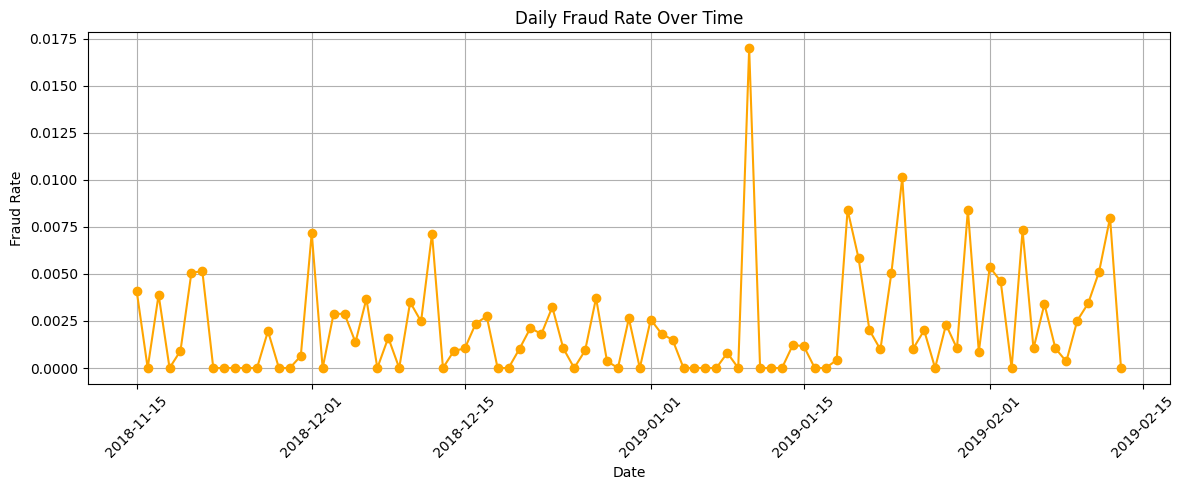

In [ ]:
# Daily target rate over time (robust)
if 'target_col' in globals() and target_col and 'time_col' in globals() and time_col:
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df = df.set_index(time_col)
    df = df.sort_index()
    daily_rate = df.groupby(df.index.date)[target_col].mean()
    plt.figure(figsize=(12, 5))
    daily_rate.plot(marker='o', linestyle='-', color='orange')
    plt.title(f"Daily {target_col} Rate Over Time")
    plt.xlabel("Date")
    plt.ylabel(f"{target_col} Rate")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('Skipping daily rate plot: missing target or time column.')

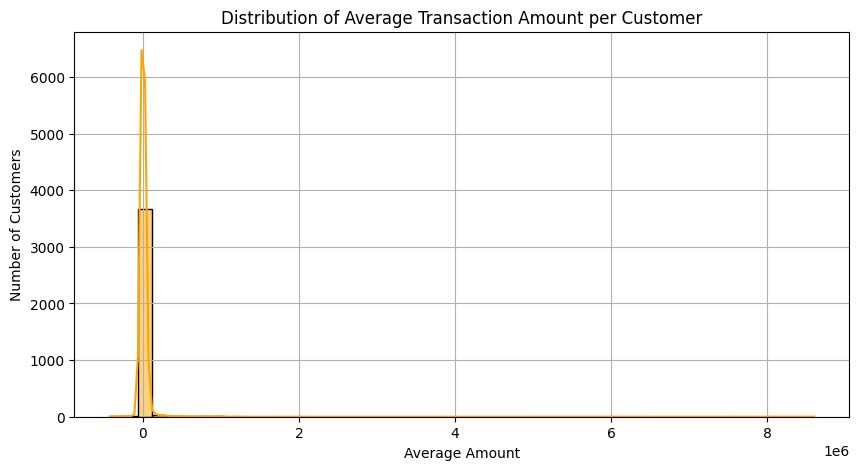

In [ ]:
# Distribution of average transaction amount per customer (robust)
if 'CustomerId' in df.columns and 'Amount' in df.columns:
    avg_amount_per_user = df.groupby('CustomerId')['Amount'].mean()
    plt.figure(figsize=(10, 5))
    sns.histplot(avg_amount_per_user, bins=50, kde=True, color='orange')
    plt.title('Distribution of Average Transaction Amount per Customer')
    plt.xlabel('Average Amount')
    plt.ylabel('Number of Customers')
    plt.grid(True)
    plt.show()
else:
    print('Skipping avg amount per customer: missing CustomerId or Amount.')

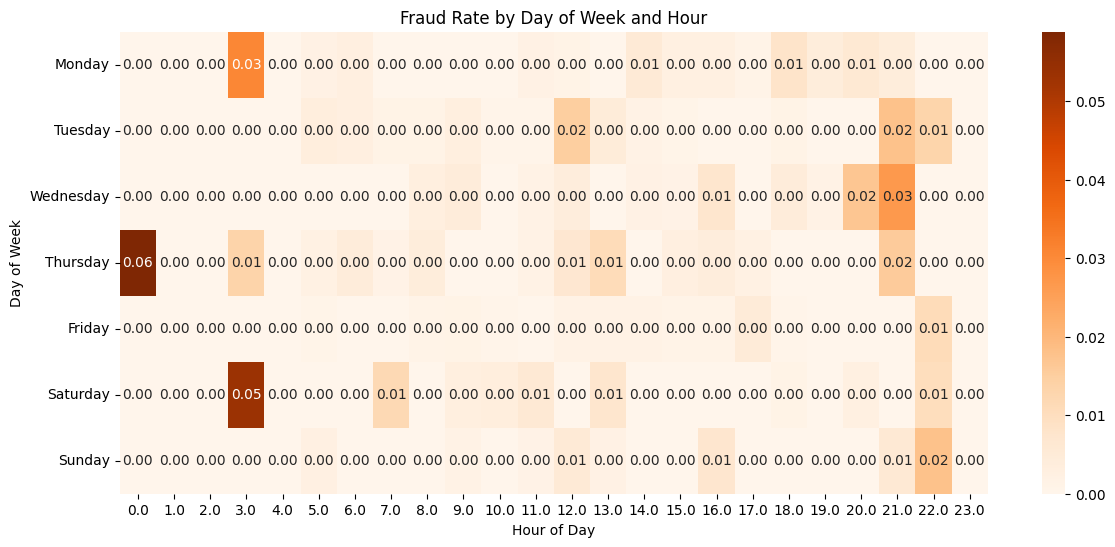

In [ ]:
# Fraud/risk rate by day of week and hour (robust)
if 'target_col' in globals() and target_col and 'time_col' in globals() and time_col:
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df = df.set_index(time_col)
    df = df.sort_index()
    tmp = df.copy()
    tmp['Hour'] = tmp.index.hour
    tmp['DayOfWeek'] = tmp.index.day_name()
    heatmap_data = tmp.pivot_table(
        index='DayOfWeek', columns='Hour', values=target_col, aggfunc='mean')

    ordered_days = ['Monday', 'Tuesday', 'Wednesday',
                    'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(ordered_days)

    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Oranges')
    plt.title(f'{target_col} Rate by Day of Week and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.show()
else:
    print('Skipping weekday-hour heatmap: missing target or time column.')

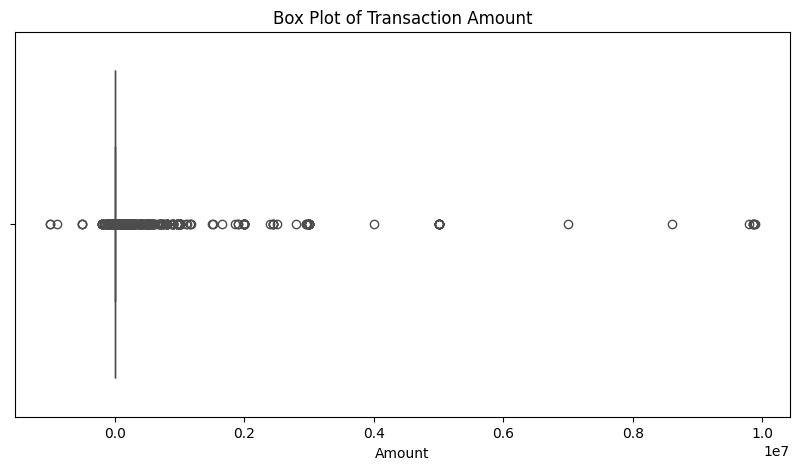

In [ ]:
# Boxplot for Amount (robust)
if 'Amount' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Amount'], color='Orange')
    plt.title('Box Plot of Transaction Amount')
    plt.show()
else:
    print('Skipping Amount boxplot: Amount column missing.')

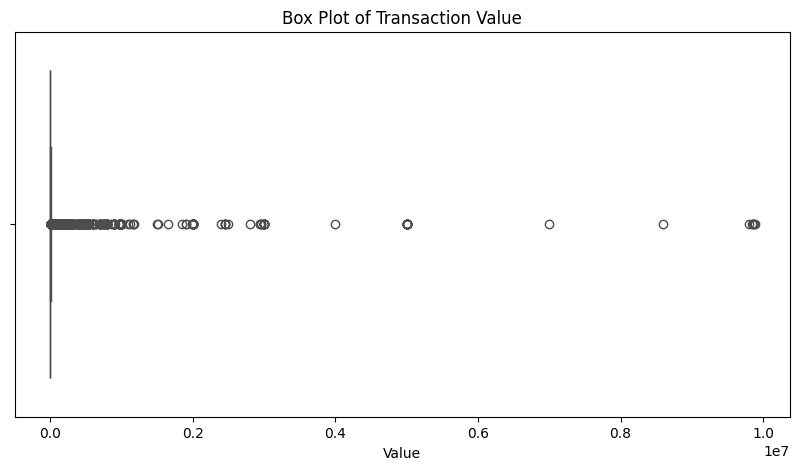

In [ ]:
# Boxplot for Value (robust)
if 'Value' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Value'], color='Orange')
    plt.title('Box Plot of Transaction Value')
    plt.show()
else:
    print('Skipping Value boxplot: Value column missing.')

In [ ]:
# RFM sanity checks
rfm_cols = {
    'Recency': ['recency', 'Recency', 'days_since_last_txn'],
    'Frequency': ['frequency', 'Frequency', 'txn_count'],
    'Monetary': ['monetary', 'Monetary', 'total_value', 'Amount', 'Value']
}

found = {}
for k, candidates in rfm_cols.items():
    found[k] = next((c for c in candidates if c in df.columns), None)
print('Detected RFM columns:', found)

if 'target_col' in globals() and target_col:
    # Compute correlations or group means where applicable
    for k, col in found.items():
        if col is None:
            print(f"Skipping {k}: no column found")
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            # Correlation with binary target (if binary)
            try:
                corr = df[[col, target_col]].dropna()
                if corr[target_col].nunique() == 2:
                    val = corr[col].corr(corr[target_col])
                    print(f"Corr({k},{target_col}) = {val:.3f}")
                # Plot distribution by target
                plt.figure(figsize=(8, 4))
                sns.kdeplot(data=df, x=col, hue=target_col,
                            common_norm=False, fill=True)
                plt.title(f"{k} distribution by {target_col}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not compute correlation/plot for {k}: {e}")
        else:
            # For categorical monetary proxies etc.
            try:
                grp = df.groupby(target_col)[col].mean(numeric_only=True)
                print(f"Mean {k} by {target_col}:\n{grp}")
            except Exception as e:
                print(f"Could not compute group means for {k}: {e}")
else:
    print('Target not available; skipping RFM sanity checks.')

# Simple leakage guard: warn if exact RFM proxy columns are slated as model inputs
leakage_candidates = [c for c in found.values() if c]
if leakage_candidates:
    print('Potential leakage columns to avoid as raw features:', leakage_candidates)
else:
    print('No explicit RFM columns detected for leakage check.')

### RFM sanity checks and leakage guard

We validate that the proxy target relates sensibly to Recency, Frequency, and Monetary metrics, and we flag any potential leakage if these metrics are reused as model inputs.


### Findings (talk track)

- Class balance: Check if `is_high_risk` is imbalanced; consider thresholding and class weights.
- Missingness: Identify columns with high NA; imputers in the pipeline handle this.
- Numeric features: Amount/Value are skewed; scaling + robust metrics applied.
- Time patterns: Spikes/seasonality can inform risk windows.
- Categories: Some products/channels/providers show higher risk; WOE encoding captures monotonic relationships.
- RFM sanity: Recency positively correlates with risk; Frequency/Monetary negatively (expected behavior).
